Deep Learning (FastText/Glove)
-----------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
from gensim.models.fasttext import FastText

from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, MaxPooling1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import codecs
from tqdm import tqdm

### Create a balanced dataset by stratifying the dataset 'https://www.kaggle.com/datasets/kazanova/sentiment140'

In [2]:
df=pd.read_csv('tweet.csv')
df.head(2)

,sentiment_label,tweet_text
0,0,visited my friends and had a great time!!! Tom...
1,0,vicar of dibley always makes me cry love them...


In [3]:
df.shape

(1600, 2)

In [4]:
df['sentiment_label'] = df.sentiment_label.replace(4, 1)

In [5]:
df['sentiment_label'].value_counts()

0    800
1    800
Name: sentiment_label, dtype: int64

#### The dataset is balanced

In [6]:
df_preprocess = df.copy()

#### Preprocess the text

In [7]:
tweets = df_preprocess.tweet_text
tweets.head()

0    visited my friends and had a great time!!! Tom...
1    vicar of dibley always makes me cry  love them...
2                 Cleaning house and fighting fatigue 
3    I can't get to sleep. I have an urge to make f...
4    HELLO ALL TWITTERS!! I've missed u. Been away ...
Name: tweet_text, dtype: object

In [8]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[0], char_list)

'visited my friends and had a great time!!! Tomorrow, up at 6:00 a.m.'

In [9]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

In [10]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [11]:
tweets_tokens = tokenize(tweets_cleaned)

In [12]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [13]:
tweets_filtered = removeSW(tweets_tokens)

#### Stemming et Lemmatisation

In [14]:
from nltk.stem import PorterStemmer
def stem(texts_filtered):
    stemmer=PorterStemmer()
    texts_stem = []

    for i, val in enumerate(texts_filtered):
        text_stem = []
        for word in val:
            text_stem.append(stemmer.stem(word))
        texts_stem.append(text_stem)
    return texts_stem

In [15]:
tweets_stem = stem(tweets_filtered)

In [16]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word))
        texts_lem.append(text_lem)
    
    return texts_lem

In [17]:
tweets_lem = lemma(tweets_stem)

In [18]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [19]:
df_preprocess['tweet'] = tweets_ready

In [20]:
df_preprocess= df_preprocess[['sentiment_label', 'tweet']]

In [21]:
df_preprocess.head(2)

,sentiment_label,tweet
0,0,visit friend great time tomorrow
1,0,vicar dibley alway make love bit


#### Utilize the Keras Tokenizer to change the texts into numbers

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_preprocess.tweet)

word_index = tokenizer.word_index
vocabulary_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocabulary_size)

Vocabulary Size : 2968


### Word Embedding with FastText

In [23]:
FASTEXT_EMB = 'wiki.simple.vec'
EMBEDDING_DIM = 300

In [24]:
embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

111052it [00:13, 8430.21it/s]

found 111052 word vectors


#### Create the embedding matrix

In [25]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [26]:
encoded_text=tokenizer.texts_to_sequences(df_preprocess.tweet)

#### Utilize padding to create sequences of same length

In [27]:
max_sequence_length = 30
X=pad_sequences(encoded_text, maxlen=max_sequence_length, padding='post')
y=df_preprocess['sentiment_label']

In [28]:
batch_size = 256
epoch = 6

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Train Data size:", len(X_train))
print("Test Data size", len(X_test))

Train Data size: 1200
Test Data size 400


In [30]:
embedding_matrix.shape

(2968, 300)

In [31]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

In [32]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [33]:
tf.random.set_seed(1)
inputs = tf.keras.Input(shape=(max_sequence_length,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# LSTM (bidirectional)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_ftx = tf.keras.Model(inputs, outputs)

2022-04-20 07:32:18.617148: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
model_ftx.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model_ftx.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           890400    
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [36]:
history_ftx = model_ftx.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/6
5/5 [==============================] - 9s 607ms/step - loss: 0.6928 - accuracy: 0.4883 - val_loss: 0.6891 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/6
5/5 [==============================] - 2s 380ms/step - loss: 0.6856 - accuracy: 0.5683 - val_loss: 0.6854 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/6
5/5 [==============================] - 2s 367ms/step - loss: 0.6775 - accuracy: 0.6175 - val_loss: 0.6774 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 4/6
5/5 [==============================] - 2s 352ms/step - loss: 0.6621 - accuracy: 0.6400 - val_loss: 0.6681 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 5/6
5/5 [==============================] - 2s 361ms/step - loss: 0.6427 - accuracy: 0.6375 - val_loss: 0.6573 - val_accuracy: 0.5975 - lr: 0.0010
Epoch 6/6
5/5 [==============================] - 2s 350ms/step - loss: 0.6155 - accuracy: 0.6700 - val_loss: 0.6646 - val_accuracy: 0.6100 - lr: 0.0010


#### Plot the learning curves for the accuracy and the loss 

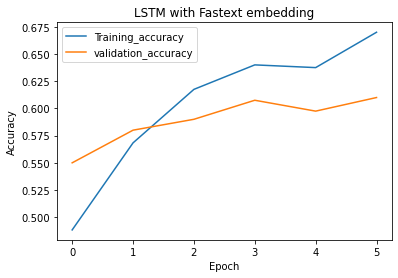

In [37]:
plt.plot(history_ftx.history['accuracy'])
plt.plot(history_ftx.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('LSTM with Fastext embedding')
plt.xlabel('Epoch')
plt.legend(['Training_accuracy', 'validation_accuracy'], loc='upper left');

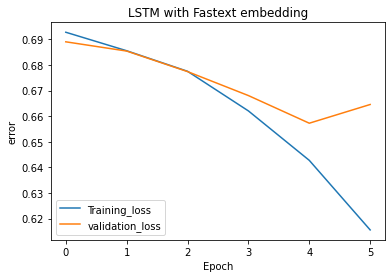

In [38]:
plt.plot(history_ftx.history['loss'])
plt.plot(history_ftx.history['val_loss'])
plt.ylabel('error')
plt.title('LSTM with Fastext embedding')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [39]:
scores = model_ftx.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

13/13 [==============================] - 0s 18ms/step - loss: 0.6646 - accuracy: 0.6100
Accuracy: 61.00%


### Save the model in a h5 format.

In [40]:
model_ftx.save("model.h5")

### Save the tokenizer in the pickle format

In [41]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=4)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
### Now open a folder 'model' and put both the 

### Word embedding  GloVe

In [42]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300

In [43]:
embeddings_index = {}
f = codecs.open(GLOVE_EMB, encoding='utf-8')
for line in tqdm(f):
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

400000it [01:05, 6114.41it/s]

Found 400000 word vectors.


In [44]:
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [45]:
embedding_matrix.shape

(2968, 300)

In [46]:
embedding_layer = tf.keras.layers.Embedding(vocabulary_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_sequence_length,
                                          trainable=False)

#### Utilize Bidirectional LSTM and GloVe embedding

In [47]:
inputs = tf.keras.Input(shape=(max_sequence_length,), dtype="int32")

x = embedding_layer(inputs)
x = SpatialDropout1D(0.2)(x)

# Bidirectional LSTM
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

# Vanilla hidden layer:
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation="sigmoid")(x)

model_glv = tf.keras.Model(inputs, outputs)

In [48]:
model_glv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
history_glv = model_glv.fit(X_train, y_train, batch_size=batch_size, epochs=epoch,
                    validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/6
5/5 [==============================] - 10s 731ms/step - loss: 0.6909 - accuracy: 0.4992 - val_loss: 0.6870 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 2/6
5/5 [==============================] - 2s 461ms/step - loss: 0.6798 - accuracy: 0.5883 - val_loss: 0.6805 - val_accuracy: 0.5825 - lr: 0.0010
Epoch 3/6
5/5 [==============================] - 2s 439ms/step - loss: 0.6692 - accuracy: 0.6200 - val_loss: 0.6701 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 4/6
5/5 [==============================] - 2s 383ms/step - loss: 0.6489 - accuracy: 0.6450 - val_loss: 0.6561 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/6
5/5 [==============================] - 2s 367ms/step - loss: 0.6159 - accuracy: 0.6625 - val_loss: 0.6518 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 6/6
5/5 [==============================] - 2s 350ms/step - loss: 0.5925 - accuracy: 0.6917 - val_loss: 0.6777 - val_accuracy: 0.6250 - lr: 0.0010


#### Plot the learning curves for the accuracy and the loss

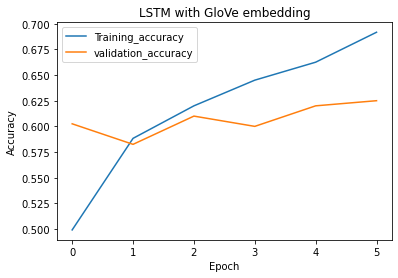

In [50]:
plt.plot(history_glv.history['accuracy'])
plt.plot(history_glv.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.title('LSTM with GloVe embedding')
plt.xlabel('Epoch')
plt.legend(['Training_accuracy', 'validation_accuracy'], loc='upper left');

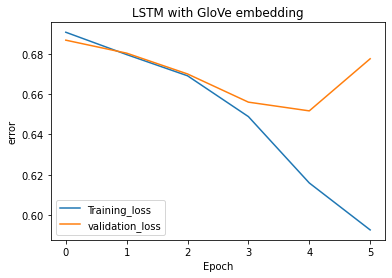

In [51]:
plt.plot(history_glv.history['loss'])
plt.plot(history_glv.history['val_loss'])
plt.ylabel('error')
plt.title('LSTM with GloVe embedding')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [52]:
scores = model_glv.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

13/13 [==============================] - 0s 22ms/step - loss: 0.6777 - accuracy: 0.6250
Accuracy: 62.50%


# Model from Scratch

### Develop a  CNN model from scratch

In [53]:
texts=df_preprocess['tweet'].tolist()

In [54]:
vocab=tokenizer.index_word

In [55]:
vocab_size=len(tokenizer.index_word)+1
vocab_size

2968

In [56]:
encoded_text=tokenizer.texts_to_sequences(texts)

In [57]:
es=EarlyStopping(monitor='val_loss', min_delta=0, mode='min', verbose=1, patience=5)

reduce_lr = ReduceLROnPlateau(factor=0.1, min_delta=0, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [59]:
embedding_dim=100

model3=Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length = max_sequence_length))

model3.add(Conv1D(64, 7, activation='relu'))
model3.add(MaxPooling1D(2))
model3.add(Dropout(0.5))

model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(16, activation='relu'))

model3.add(GlobalMaxPooling1D())

model3.add(Dense(1, activation='sigmoid'))

In [60]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
history=model3.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/6
38/38 [==============================] - 2s 22ms/step - loss: 0.6944 - accuracy: 0.4958 - val_loss: 0.6927 - val_accuracy: 0.5275 - lr: 0.0010
Epoch 2/6
38/38 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5100 - val_loss: 0.6923 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 3/6
38/38 [==============================] - 1s 15ms/step - loss: 0.6856 - accuracy: 0.5483 - val_loss: 0.6921 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 4/6
38/38 [==============================] - 1s 15ms/step - loss: 0.6623 - accuracy: 0.5817 - val_loss: 0.6814 - val_accuracy: 0.5675 - lr: 0.0010
Epoch 5/6
38/38 [==============================] - 1s 16ms/step - loss: 0.5597 - accuracy: 0.7425 - val_loss: 0.7028 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/6
38/38 [==============================] - 1s 16ms/step - loss: 0.3932 - accuracy: 0.8533 - val_loss: 0.7920 - val_accuracy: 0.6250 - lr: 0.0010


In [62]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           296800    
                                                                 
 conv1d (Conv1D)             (None, 24, 64)            44864     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 64)           0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 12, 64)            0         
                                                                 
 dense_4 (Dense)             (None, 12, 32)            2080      
                                                                 
 dropout_3 (Dropout)         (None, 12, 32)            0         
                                                        

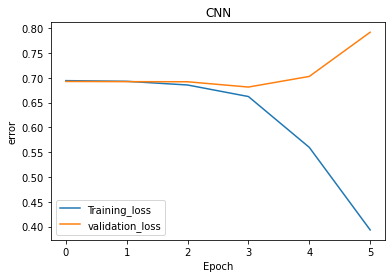

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('error')
plt.title('CNN')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [64]:
scores = model3.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

13/13 [==============================] - 0s 3ms/step - loss: 0.7920 - accuracy: 0.6250
Accuracy: 62.50%


### Using a  LSTM model from scratch

In [65]:
embedding_dim = 100

model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim,input_length = max_sequence_length))
model4.add(SpatialDropout1D(0.2))
model4.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model4.add(Dense(1, activation='sigmoid'))

In [66]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
history=model4.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), callbacks= [es, reduce_lr])

Epoch 1/6
38/38 [==============================] - 6s 73ms/step - loss: 0.6935 - accuracy: 0.5058 - val_loss: 0.6965 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 2/6
38/38 [==============================] - 2s 55ms/step - loss: 0.6953 - accuracy: 0.4867 - val_loss: 0.6933 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 3/6
38/38 [==============================] - 2s 53ms/step - loss: 0.6933 - accuracy: 0.4933 - val_loss: 0.6929 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 4/6
38/38 [==============================] - 2s 48ms/step - loss: 0.5877 - accuracy: 0.7017 - val_loss: 0.6841 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/6
38/38 [==============================] - 2s 50ms/step - loss: 0.4094 - accuracy: 0.8567 - val_loss: 0.7530 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/6
38/38 [==============================] - 2s 62ms/step - loss: 0.2731 - accuracy: 0.9033 - val_loss: 0.8786 - val_accuracy: 0.6200 - lr: 0.0010


In [68]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 100)           296800    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 30, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 339,105
Trainable params: 339,105
Non-trainable params: 0
_________________________________________________________________


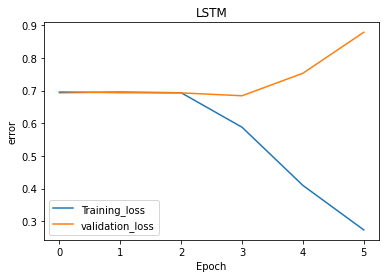

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('error')
plt.title('LSTM')
plt.xlabel('Epoch')
plt.legend(['Training_loss', 'validation_loss'], loc='lower left');

In [70]:
scores = model4.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

13/13 [==============================] - 0s 7ms/step - loss: 0.8786 - accuracy: 0.6200
Accuracy: 62.00%


## So the best accuracy is obtained by the Bi-LSTM GloVe model.

### Now we try to deploy the fastText model in Microsoft Azure.